function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,60000)

In [1]:
%config Completer.use_jedi = True
from sklearn.linear_model import LogisticRegression
import numpy as np
import math
from tqdm import tqdm
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
sns.set(style="darkgrid",rc={'figure.figsize':(15,8)})


from sklearn.ensemble import RandomForestClassifier


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
def mean_encoder(df, featureNames, targetName):
    dict_mappings = {}
    for feature in featureNames:
        Mean_encoded_feature = df.groupby([feature])[targetName].mean().to_dict()
        df[feature] =  df[feature].map(Mean_encoded_feature).astype(float, errors = 'raise')
        dict_mappings[feature] = Mean_encoded_feature
    return dict_mappings

trainTransact = pd.read_csv('data/train_transaction.csv')
trainId = pd.read_csv('data/train_identity.csv')

trainTransact.set_index('TransactionID',inplace=True)
trainId.set_index('TransactionID',inplace=True)

In [4]:
#train = trainTransact.join(trainId, how= 'outer')
train = pd.read_csv('trainSet.csv').drop(columns='TransactionID')
train

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# separo el 10% del train para usarlo de validation
fechaCorte = int((train['TransactionDT'].max() - train['TransactionDT'].min()) *0.9) + train['TransactionDT'].min()
validationSet = train.loc[train['TransactionDT'] > fechaCorte]
validationSetX = validationSet.drop(columns='isFraud')
validationSetY = validationSet['isFraud']

In [6]:
train = train.loc[train['TransactionDT'] <= fechaCorte]

In [7]:
# encoding de trainX
mappings = mean_encoder(train, ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2','M3','M4','M5','M6','M7','M8','M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27','id_28','id_29','id_30','id_31','id_33','id_34','id_35','id_36','id_37','id_38','DeviceType','DeviceInfo'], 'isFraud')
# encoding de validationX
for feature, mapsDict in mappings.items():
    validationSetX[feature] = validationSetX[feature].map(mapsDict)

<ipython-input-3-33bc16ff3a99>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] =  df[feature].map(Mean_encoded_feature).astype(float, errors = 'raise')


In [8]:
trainX = train.drop(columns='isFraud')
trainY = train['isFraud']

In [9]:
trainX.fillna(value=0, inplace=True)
validationSetX.fillna(value=0, inplace=True)

In [ ]:
model = LogisticRegression(random_state = 2209, max_iter = 500)
parameters = {'C': (0.2, 0.4, 0.5, 0.6, 0.8), 'solver' : ('lbfgs', 'liblinear')}
clf = RandomizedSearchCV(model, parameters, n_iter=4, n_jobs=1, verbose=100, cv=3, random_state=2209, scoring='roc_auc')
clf.fit(trainX.values, trainY.values)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START C=0.5, solver=liblinear.....................................
[CV 1/3; 1/4] END ......C=0.5, solver=liblinear;, score=0.562 total time=  14.6s
[CV 2/3; 1/4] START C=0.5, solver=liblinear.....................................
[CV 2/3; 1/4] END ......C=0.5, solver=liblinear;, score=0.618 total time= 1.3min
[CV 3/3; 1/4] START C=0.5, solver=liblinear.....................................
[CV 3/3; 1/4] END ......C=0.5, solver=liblinear;, score=0.722 total time= 1.8min
[CV 1/3; 2/4] START C=0.2, solver=liblinear.....................................
[CV 1/3; 2/4] END ......C=0.2, solver=liblinear;, score=0.562 total time=  12.2s
[CV 2/3; 2/4] START C=0.2, solver=liblinear.....................................
[CV 2/3; 2/4] END ......C=0.2, solver=liblinear;, score=0.636 total time= 1.5min
[CV 3/3; 2/4] START C=0.2, solver=liblinear.....................................
[CV 3/3; 2/4] END ......C=0.2, solver=liblinear;,

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/3; 3/4] END ..........C=0.2, solver=lbfgs;, score=0.684 total time= 2.8min
[CV 3/3; 3/4] START C=0.2, solver=lbfgs.........................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/3; 3/4] END ..........C=0.2, solver=lbfgs;, score=0.707 total time= 2.6min
[CV 1/3; 4/4] START C=0.8, solver=lbfgs.........................................
[CV 1/3; 4/4] END ..........C=0.8, solver=lbfgs;, score=0.689 total time= 1.5min
[CV 2/3; 4/4] START C=0.8, solver=lbfgs.........................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/3; 4/4] END ..........C=0.8, solver=lbfgs;, score=0.684 total time= 2.8min
[CV 3/3; 4/4] START C=0.8, solver=lbfgs.........................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/3; 4/4] END ..........C=0.8, solver=lbfgs;, score=0.704 total time= 2.6min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(max_iter=500,
                                                random_state=2209),
                   n_iter=4, n_jobs=1,
                   param_distributions={'C': (0.2, 0.4, 0.5, 0.6, 0.8),
                                        'solver': ('lbfgs', 'liblinear')},
                   random_state=2209, scoring='roc_auc', verbose=100)

In [ ]:
# descargo modelo
import pickle
with open('/content/drive/Othercomputers/Gabriel-G5/FIUBA/ORGADATOS/TP3/data/model_backup', 'wb') as model_backup_file:
    pickle.dump(clf, model_backup_file)

In [9]:
import pickle
with open('data/model_backup', 'rb') as file:
    clf = pickle.load(file)

In [5]:
clf.best_params_

{'solver': 'lbfgs', 'C': 0.8}

In [10]:
preds = clf.predict(validationSetX.values)
preds_proba = clf.predict_proba(validationSetX.values)

In [ ]:
print(classification_report(validationSetY.values, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     48631
           1       0.18      0.00      0.00      1905

    accuracy                           0.96     50536
   macro avg       0.57      0.50      0.49     50536
weighted avg       0.93      0.96      0.94     50536



In [ ]:
roc_auc_score(validationSetY, preds_proba[:,1])

0.7237591178218143

¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el dataset para validar?)

---
El mejor score (auc roc) es 0.7237 y el dataset de validacion lo obtuve tomando el 10% del train set con el TransactionDT mas grande, de tal forma que el modelo no se entrene con datos futuros a los de validacion.

In [ ]:
# cargo test y predigo para mandar a la competencia
testTransact = pd.read_csv('/content/drive/Othercomputers/Gabriel-G5/FIUBA/ORGADATOS/TP3/data/test_transaction.csv')
testId = pd.read_csv('/content/drive/Othercomputers/Gabriel-G5/FIUBA/ORGADATOS/TP3/data/test_identity.csv')
testTransact.set_index('TransactionID',inplace=True)
testId.set_index('TransactionID',inplace=True)
test = testTransact.join(testId, how= 'outer')
testId = None
testTransact = None

In [ ]:
test.rename(inplace=True, columns={"id-01":"id_01", "id-02":"id_02","id-03":"id_03","id-04":"id_04","id-05":"id_05","id-06":"id_06","id-07":"id_07","id-08":"id_08","id-09":"id_09","id-11":"id_11","id-12":"id_12","id-13":"id_13","id-14":"id_14","id-15":"id_15","id-16":"id_16","id-17":"id_17","id-18":"id_18","id-19":"id_19","id-20":"id_20","id-21":"id_21","id-22":"id_22","id-23":"id_23","id-24":"id_24","id-25":"id_25","id-26":"id_26","id-27":"id_27","id-28":"id_28","id-29":"id_29","id-30":"id_30","id-31":"id_31","id-32":"id_32","id-33":"id_33","id-34":"id_34","id-35":"id_35","id-36":"id_36","id-37":"id_37","id-38":"id_38",})
for feature, mapsDict in mappings.items():
    test[feature] = test[feature].map(mapsDict)

In [ ]:
test.fillna(value=0, inplace=True)

In [ ]:
testpreds = clf.predict_proba(test.values)[:,1]
testpreds

array([0.00537475, 0.00503278, 0.0012683 , ..., 0.00668423, 0.00821235,
       0.13085527])

In [ ]:
pd.DataFrame(testpreds, index=test.index ).rename(columns={0:'isFraud'}).to_csv('/content/drive/Othercomputers/Gabriel-G5/FIUBA/ORGADATOS/TP3/data/late_submission.csv')

Al predecir con este modelo para la competencia, ¿Cúal es el score obtenido?
(guardar el csv con predicciones para entregarlo después)

---
Obtuve 0.709451


In [7]:
# obtengo los coeficientes para ver las features mas importantes
coefs = clf.best_estimator_.coef_[0]

In [17]:
coefsdata = pd.DataFrame.from_dict({x:y for x,y in zip(trainX.columns, coefs)}, orient='index').rename(columns={0:'proba'})

In [18]:
fraud = []
for proba in coefsdata.values:
  if proba[0] >= 0: fraud.append(1)
  else: fraud.append(0)

coefsdata['fraud'] = fraud
coefsdata = coefsdata.apply(lambda x: abs(x))

In [19]:
coefsdata['norm'] = coefsdata['proba'] / trainX.mean(axis=0)

In [20]:
coefsdata

,proba,fraud,norm
TransactionDT,3.684820e-08,0,5.534094e-15
TransactionAmt,7.558719e-04,0,5.610379e-06
ProductCD,5.941970e-08,0,1.710570e-06
card1,5.653902e-05,0,5.722779e-09
card2,2.663813e-03,0,7.467356e-06
...,...,...,...
id_36,1.006666e-08,1,5.353066e-07
id_37,6.226849e-09,1,3.311200e-07
id_38,3.818227e-08,1,2.030387e-06
DeviceType,2.773543e-08,1,1.475736e-06


In [30]:
top20norm = coefsdata.nlargest(20, columns='norm')

In [31]:
top20norm

,proba,fraud,norm
V232,1.374704e-05,1,0.000076
V233,1.138383e-05,1,0.000071
V231,8.844931e-06,1,0.000067
id_03,4.661351e-07,1,0.000067
V147,1.424969e-06,1,0.000062
DeviceInfo,8.200782e-07,1,0.000057
V239,1.828066e-06,1,0.000057
V177,7.086527e-06,1,0.000056
V217,1.005175e-05,1,0.000052
V219,1.281331e-05,1,0.000050


Text(0.5, 1.0, 'Importancia (normalizada) de los Features')

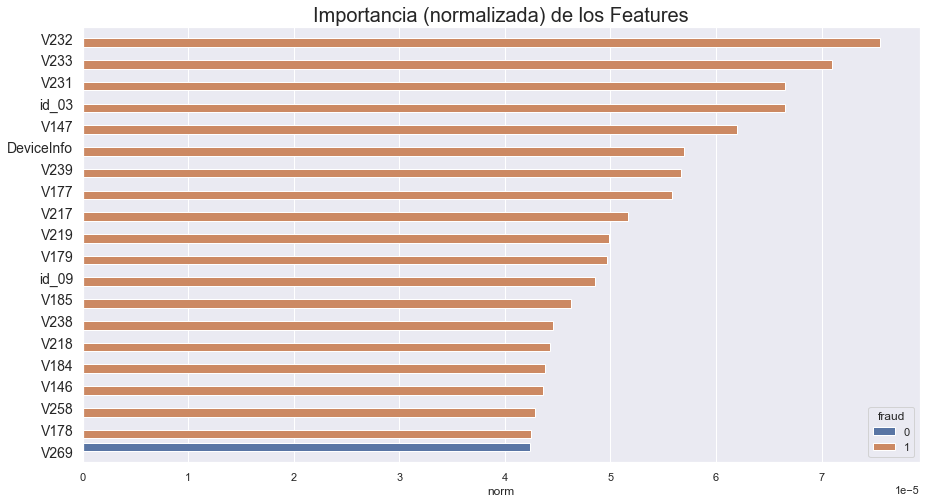

In [33]:
barnorm = sns.barplot(x=top20norm['norm'], y=top20norm.index, hue=top20norm['fraud'])
barnorm.set_yticklabels(top20norm.index, fontsize=14, rotation=0, ha= 'right')
barnorm.set_title('Importancia (normalizada) de los Features', fontsize=20)